In [5]:
import os
import csv
import sys
import random
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import roc_auc_score

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

In [6]:
ll ../results

total 64144
-rw-r--r--  1 npt2105  staff   660500 Apr 14 10:29 final-bydrug-test_0_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff   660500 Apr 14 10:29 final-bydrug-test_1_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff   660500 Apr 14 10:29 final-bydrug-test_2_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff   660500 Apr 14 10:29 final-bydrug-test_3_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff   660500 Apr 14 10:29 final-bydrug-test_4_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff  4418450 Apr 14 10:29 final-bydrug-train_0_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff  4418450 Apr 14 10:29 final-bydrug-train_1_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff  4418450 Apr 14 10:29 final-bydrug-train_2_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff  4418450 Apr 14 10:29 final-bydrug-train_3_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff  4418450 Apr 14 10:29 final-bydrug-train_4_222_24_25_1e-06.csv
-rw-r--r--  1 npt2105  staff   590900 Apr 14 10:29 final-bydrug-valid_0_2

In [28]:
split = 'test'
results_files = [f'../results/final-bydrug-{split}_0_222_24_25_1e-06.csv', 
                 f'../results/final-bydrug-{split}_1_222_24_25_1e-06.csv',
                 f'../results/final-bydrug-{split}_2_222_24_25_1e-06.csv',
                 f'../results/final-bydrug-{split}_3_222_24_25_1e-06.csv',
                 f'../results/final-bydrug-{split}_4_222_24_25_1e-06.csv']

In [29]:
labels = {'not_event': 0, 'is_event': 1}

In [30]:
datapath = '../data/clinical_bert_reference_set.txt'
df = pd.read_csv(datapath)
df.head()

,drug,llt_id,llt,class,string
0,Cimzia,35104113,pancytopenia,is_event,"pancytopenia arthralgia (6% cimzia, 4% placebo..."
1,Cimzia,35104746,lymphadenopathy,is_event,"lymphadenopathy and arthralgia (6% cimzia, 4% ..."
2,Cimzia,35104868,leukopenia,is_event,"leukopenia patients, and arthralgia (6% cimzia..."
3,Cimzia,35122651,anemia,is_event,"anemia placebo-treated patients, and arthralgi..."
4,Cimzia,35122884,cytopenia,not_event,"cytopenia (6% cimzia, 4% placebo). other adver..."


In [31]:
refset_names = {
    0: 'Substitute Term, Prepend Term',
    1: 'Prepend Term Only',
    2: 'Substitute Term Only',
    3: 'No Changes',
    4: 'Subsitute with Nonsense'
}

 refset: 0
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 valid thresh: 1.23171865940094
 test thresh : 1.234086662530899

 refset: 1
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 valid thresh: 2.0782055854797363
 test thresh : 2.075490713119507

 refset: 2
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 valid thresh: 1.2331154346466064
 test thresh : 1.244469592968623

 refset: 3
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 valid thresh: 0.2795543074607849
 test thresh : 0.2845891714096069

 refset: 4
 np_random_seed: 222
 random_state: 24
 EPOCHS: 25
 LR: 1e-06
 valid thresh: 2.5297276973724365
 test thresh : 2.5217596081395945



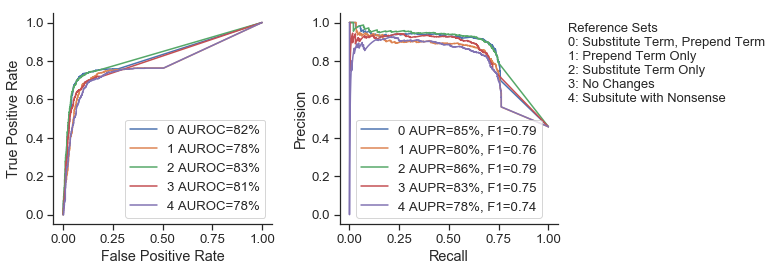

In [40]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(11,4))
first = True

if split == 'valid':
    max_f1_thresholds = dict()

for resultspath in results_files:
    refset = resultspath.split('_')[1]
    np_random_seed = int(resultspath.split('_')[2])
    random_state = int(resultspath.split('_')[3])
    EPOCHS = int(resultspath.split('_')[4])
    LR = resultspath.split('_')[5].split('.')[0]

    print(f" refset: {refset}")
    print(f" np_random_seed: {np_random_seed}")
    print(f" random_state: {random_state}")
    print(f" EPOCHS: {EPOCHS}")
    print(f" LR: {LR}")
    
    druglist = sorted(set(df['drug']))

    random.seed(np_random_seed)
    random.shuffle(druglist)

    drugs_train, drugs_val, drugs_test = np.split(druglist, [int(0.8*len(druglist)), int(0.9*len(druglist))])

    len(drugs_train), len(drugs_val), len(drugs_test)

    df_train = df[df['drug'].isin(drugs_train)]
    df_val = df[df['drug'].isin(drugs_val)]
    df_test = df[df['drug'].isin(drugs_test)]

    #df_train.shape, df_val.shape, df_test.shape
    
    if split == 'test':
        df_touse = df_test
        drugs_touse = drugs_test
    elif split == 'valid':
        df_touse = df_val
        drugs_touse = drugs_val
    elif split == 'train':
        df_touse = df_train
        drugs_touse = drugs_train
    else:
        raise Exception(f"Split has unexpected value: {split}")
    
    refset_fn = '../data/200_manual_annotations_csv/FinalReferenceStandard200Labels.csv'
    refset_fh = open(refset_fn)
    reader = csv.reader(refset_fh, delimiter='|')
    header = next(reader)

    gold_standard = set()
    for row in reader:
        data = dict(zip(header, row))
        if data['Section Display Name'] != 'ADVERSE REACTIONS':
            continue

        if not data['Drug Name'] in drugs_touse:
            continue

        gold_standard.add((data['Drug Name'], data['Matching String'].lower()))
    
    refset_fh.close()
    len(gold_standard)

    
    res = pd.read_csv(resultspath, header=None)
    
    df_touse['Pred0'] = res[0].to_numpy()
    df_touse['Pred1'] = res[1].to_numpy()
    
    df_touse_grouped = df_touse[['drug', 'llt', 'Pred1', 'Pred0']].groupby(by=['drug', 'llt']).mean().reset_index()
    
    
    # for all of the drug, event pairs that couldn't be scored we add them with 0's 
    # otherwise we will way overestimate our recall
    scored_pairs = set()
    for index, row in df_touse_grouped.iterrows():
        scored_pairs.add((row['drug'], row['llt']))

    for d, e in (gold_standard-scored_pairs):
        df_touse_grouped = df_touse_grouped.append({'drug': d, 'llt': e, 'Pred1': 0.0, 'Pred0': 0.0}, ignore_index=True)
    
    grouped_y = [1 if ((row['drug'], row['llt']) in gold_standard) else 0 for index, row in df_touse_grouped.iterrows()]
    
    plt.subplot(1, 2, 1)
    fpr, tpr, thresholds = metrics.roc_curve(grouped_y, df_touse_grouped['Pred1'])
    plt.plot(fpr, tpr, label='%s AUROC=%.0f%%' % (refset, 100*roc_auc_score(grouped_y, df_touse_grouped['Pred1'])))
    plt.legend()
    if first:
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        sns.despine()
    
    plt.subplot(1, 2, 2)
    precision, recall, thresholds = metrics.precision_recall_curve(grouped_y, df_touse_grouped['Pred1'])
    numerator = 2 * recall * precision
    denom = recall + precision
    f1_scores = np.divide(numerator, denom, out=np.zeros_like(denom), where=(denom!=0))
    max_f1 = np.max(f1_scores)
    max_f1_thresh = thresholds[np.argmax(f1_scores)]
    
    if split == 'valid':
        max_f1_thresholds[resultspath] = (max_f1_thresh, max_f1)
    
    if split == 'test':
        # if this is test, we use the max_f1_threshold from the validation set
        # you must run this entire notebook through for the validation set first
        # otherwise you will an error that the dictionary is not defined
        vthresh = max_f1_thresholds[resultspath.replace('test', 'valid')][0]
        tthresh = thresholds[np.argmin(np.abs(thresholds-vthresh))]
        test_f1_score = f1_scores[np.argmin(np.abs(thresholds-vthresh))]
        
        # overwrite the max_f1 so that we don't need a new label line
        max_f1 = test_f1_score
        
        print(f" valid thresh: {vthresh}")
        print(f" test thresh : {tthresh}")
    
    print("")
    
    plt.plot(recall, precision, label='%s AUPR=%.0f%%, F1=%.2f' % (refset, 100*metrics.auc(recall, precision), max_f1))
    plt.legend()
    if first:
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        sns.despine()
    
    first = False

reflegend = 'Reference Sets\n' + '\n'.join([f"{i}: {s}" for i, s in refset_names.items()])
plt.text(1.1, 1.0, reflegend, fontsize=13, verticalalignment='top')
plt.tight_layout()
plt.savefig(f'../figures/{split}perf_groupedallse_compare_{np_random_seed}_{random_state}_{EPOCHS}_{LR}.pdf')

In [41]:
max_f1_thresholds

{'../results/final-bydrug-valid_0_222_24_25_1e-06.csv': (1.23171865940094,
  0.7739905610907184),
 '../results/final-bydrug-valid_1_222_24_25_1e-06.csv': (2.0782055854797363,
  0.7668231611893583),
 '../results/final-bydrug-valid_2_222_24_25_1e-06.csv': (1.2331154346466064,
  0.7810026385224275),
 '../results/final-bydrug-valid_3_222_24_25_1e-06.csv': (0.2795543074607849,
  0.7570385818561001),
 '../results/final-bydrug-valid_4_222_24_25_1e-06.csv': (2.5297276973724365,
  0.7558139534883721)}